<a href="https://colab.research.google.com/github/ayarii/learner-engagement/blob/main/learner_'s_engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Import data from Google Drive**

In [2]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile

In [3]:
#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))

40112536/40112536 [==============================] - 0s 0us/step
/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [4]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

6


Populating the interactive namespace from numpy and matplotlib
Shape of the image (21216,)


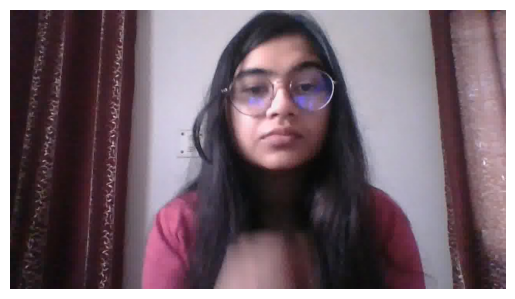

Shape of the image (14893,)


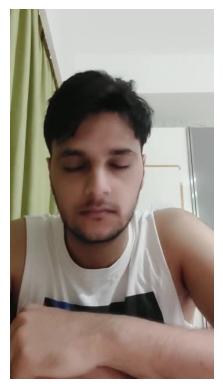

In [34]:
%pylab inline

url_engaged = r'https://github.com/ayarii/learner-engagement/blob/main/0076.jpg?raw=true'
resp = requests.get(url_engaged, stream=True).raw
image_array_engagement = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_engagement.shape}')
image_engagement = cv2.imdecode(image_array_engagement, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB)) 
plt.show()

url_notEngaged = r'https://github.com/ayarii/learner-engagement/blob/main/0025.jpg?raw=true'
resp = requests.get(url_notEngaged, stream=True).raw
image_array_notEngaged = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_notEngaged.shape}')
image_notEngaged = cv2.imdecode(image_array_notEngaged, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_notEngaged, cv2.COLOR_BGR2RGB))
plt.show()
     

In [5]:
batch_size = 3
img_height = 200
img_width = 200
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 2120 files belonging to 2 classes.
Using 1696 files for training.
Found 2120 files belonging to 2 classes.
Using 424 files for validation.
['Engaged', 'Not engaged']


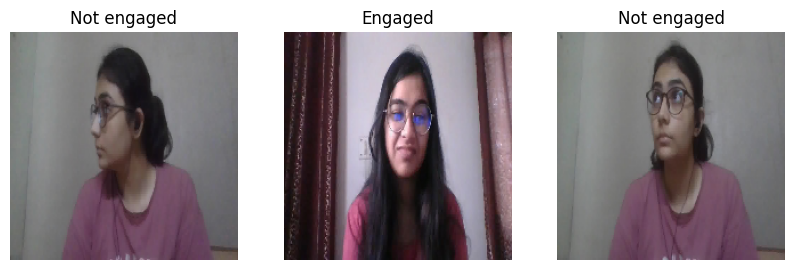

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
from tensorflow.keras import layers

num_classes = 2

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    #Cette ligne définit une couche de convolution 2D avec 128 filtres (aussi appelés kernels) de taille 4x4. 
    #La fonction d'activation 'relu' (Rectified Linear Unit) est utilisée pour introduire une non-linéarité dans la sortie de cette couche. 
    #La couche de convolution est responsable de l'extraction des caractéristiques des données d'entrée à l'aide de ces filtres.
    layers.Conv2D(128,4, activation='relu'),
    #Cette ligne représente une couche de pooling 2D. 
    #Le pooling est une opération qui réduit la dimension spatiale des caractéristiques extraites par la couche de convolution précédente. 
    #Ici, aucune taille spécifique n'est définie pour le pooling, donc les paramètres par défaut seront utilisés
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    #Cette ligne représente une couche de mise à plat (flatten).
    #Elle est utilisée pour convertir les caractéristiques extraites précédemment en un vecteur unidimensionnel.
    #Cette opération est nécessaire avant de passer aux couches entièrement connectées.
    layers.Flatten(),
    # Cette ligne définit une couche dense (fully connected) avec 64 neurones. 
    #Chaque neurone est connecté à tous les neurones de la couche précédente. 
    #La fonction d'activation 'relu' est utilisée pour introduire une non-linéarité dans la sortie de cette couche.
    layers.Dense(64,activation='relu'),
    #Cette ligne représente la dernière couche dense du modèle. Le nombre de neurones dans cette couche est défini par la variable num_classes, qui correspond au nombre de classes dans le problème de classification.
    #La fonction d'activation 'softmax' est utilisée pour obtenir des probabilités normalisées pour chaque classe de sortie. 
    #Cela permet de modéliser la distribution de probabilités sur les classes et de choisir la classe la plus probable lors de la prédiction.
    layers.Dense(num_classes, activation='softmax')
])
#Cette ligne compile le modèle en spécifiant l'optimiseur, la fonction de perte et les métriques à utiliser lors de l'entraînement. 
#Dans cet exemple, l'optimiseur Adam est utilisé, la fonction de perte est la perte croisée catégorielle clairsemée (SparseCategoricalCrossentropy) avec les logits en tant qu'entrée, et la métrique utilisée pour évaluer les performances du modèle est l'exactitude (accuracy).
model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'],)
#Cette ligne définit le répertoire dans lequel les journaux (logs) de TensorBoard seront enregistrés.
logdir="logs"
#Cette ligne crée un rappel (callback) de TensorBoard pour enregistrer les journaux et visualiser les métriques et les graphiques lors de l'entraînement.
#Le paramètre log_dir spécifie le répertoire de stockage des journaux, histogram_freq=1 signifie que les histogrammes des poids du modèle seront enregistrés à chaque époque, write_images=logdir enregistre les images des données d'entrée, et embeddings_data=train_data spécifie les données d'entraînement utilisées pour les visualisations d'incorporation (embeddings).
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,embeddings_data=train_data)
#Cette ligne lance l'entraînement du modèle.
#train_data est l'ensemble de données d'entraînement, validation_data=val_data est l'ensemble de données de validation utilisé pour évaluer le modèle à la fin de chaque époque, epochs=2 spécifie le nombre d'époques d'entraînement, et callbacks=[tensorboard_callback] indique d'utiliser le rappel de TensorBoard pour enregistrer les journaux.
model.fit( 
  train_data,
  validation_data=val_data,
  epochs=2,
  callbacks=[tensorboard_callback]
)
#En résumé, le code compile le modèle en spécifiant l'optimiseur, la fonction de perte et les métriques, puis entraîne le modèle sur les données d'entraînement et évalue les performances sur les données de validation. 
#Les journaux sont enregistrés pour permettre une analyse plus détaillée des métriques et des visualisations via TensorBoard.


Epoch 1/2
566/566 [==============================] - 797s 1s/step - loss: 0.2904 - accuracy: 0.8732 - val_loss: 0.0787 - val_accuracy: 0.9764
Epoch 2/2
566/566 [==============================] - 756s 1s/step - loss: 0.0176 - accuracy: 0.9976 - val_loss: 0.0050 - val_accuracy: 0.9976


In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 197, 197, 128)     6272      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 98, 98, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 95, 95, 64)        131136    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 44, 44, 32)       

Saving 0035.jpg to 0035.jpg


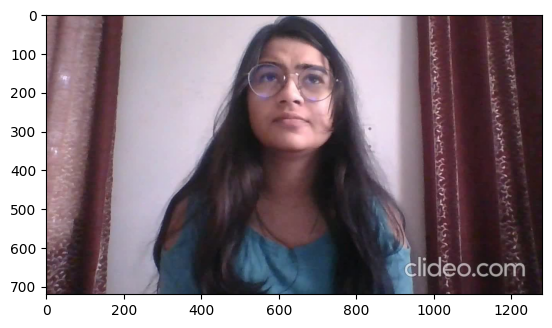

1/1 [==============================] - 0s 103ms/step


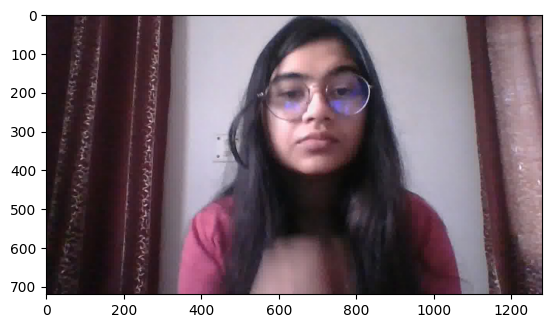

Learner Engaged!


In [40]:
# Cette ligne importe la bibliothèque "files" de Google Colab, qui permet de charger des fichiers depuis votre ordinateur vers l'environnement Colab.
from google.colab import files
# Cette ligne demande à l'utilisateur de télécharger un fichier (une image dans ce cas) vers l'environnement Colab. Le fichier téléchargé sera stocké dans la variable file_to_predict.
file_to_predict = files.upload()
# Cette ligne itère sur les fichiers téléchargés (dans le cas où plusieurs fichiers auraient été téléchargés) et effectue les étapes suivantes pour chaque fichier.
for file_ in file_to_predict:
  #Cette ligne utilise la fonction cv2.imread de la bibliothèque OpenCV pour lire l'image téléchargée à partir du fichier.
  #L'image est stockée dans la variable image_to_predict.
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    #Cette ligne affiche l'image en utilisant plt.imshow de la bibliothèque matplotlib. 
    #cv2.cvtColor est utilisé pour convertir l'image du format BGR (utilisé par OpenCV) en format RGB (utilisé par matplotlib).
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    #Cette ligne redimensionne l'image à une taille de 200x200 pixels à l'aide de cv2.resize et l'expands en ajoutant une dimension supplémentaire à l'aide de np.expand_dims.
    #Cela est nécessaire pour que l'image corresponde à la forme attendue par le modèle (une seule image avec les dimensions spécifiées).
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(200,200)), axis=0) 
    #Cette ligne effectue la prédiction en utilisant le modèle CNN entraîné (model.predict). La variable res contient les résultats de la prédiction.
    res = model.predict(img_to_predict)
predicted_class = np.argmax(res)  # Obtient l'indice de la classe prédite avec la plus haute probabilité
if predicted_class == 0:
    plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Engaged!")
elif predicted_class == 1:
    plt.imshow(cv2.cvtColor(image_notEngaged, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Not engaged!")
#Ce code permet de charger une image, de faire des prédictions avec le modèle CNN et d'afficher une image correspondant